In [1]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc

In [2]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [ 178.478431, -17.6426563 ], 
            [ 178.4875358, -17.6427653 ], 
            [ 178.5163223, -17.6076001 ], 
            [ 178.5020381, -17.6065642 ], 
            [ 178.478431, -17.6426563 ],
        ]
    ],
}

In [3]:
time_of_interest = "2020-01-01/2021-08-31"

In [6]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = catalog.search(
    collections=["landsat-8-c2-l2"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 20}},
)

# Check how many items were returned
items = list(search.get_items())
print(f"Returned {len(items)} Items")

Returned 5 Items


In [7]:
selected_item = sorted(items, key=lambda item: eo.ext(item).cloud_cover)[0]

print(
    f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
    + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
)

Choosing LC08_L2SR_074072_20210424_02_T1 from 2021-04-24 with 6.55% cloud cover


In [8]:
def find_asset_by_band_common_name(item, common_name):
    for asset in item.assets.values():
        asset_bands = eo.ext(asset).bands
        if asset_bands and asset_bands[0].common_name == common_name:
            return asset
    raise KeyError(f"{common_name} band not found")

In [9]:
asset_hrefs = [
    find_asset_by_band_common_name(selected_item, "red").href,
    find_asset_by_band_common_name(selected_item, "green").href,
    find_asset_by_band_common_name(selected_item, "blue").href,
]

In [10]:
signed_hrefs = [pc.sign(asset_href) for asset_href in asset_hrefs]

In [11]:
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp

import numpy as np
from PIL import Image


def read_band(href):
    with rasterio.open(href) as ds:
        aoi_bounds = features.bounds(area_of_interest)
        warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        return ds.read(1, window=aoi_window)


bands = [read_band(href) for href in signed_hrefs]

In [12]:
multiband_data = np.stack(bands)

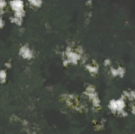

In [13]:
rescaled = multiband_data.astype(float)
min_value, max_value = rescaled.min(), rescaled.max()
rescaled = ((rescaled - min_value) * 255) / (max_value - min_value)
byte_data = rescaled.astype("ubyte")
Image.fromarray(np.transpose(byte_data, axes=[1, 2, 0]))

In [14]:
r = read_band(
    pc.sign(find_asset_by_band_common_name(selected_item, "red").href)
).astype(float)

nir = read_band(
    pc.sign(find_asset_by_band_common_name(selected_item, "nir08").href)
).astype(float)

ndvi = (nir - r) / (nir + r)
w = ndvi.shape[0]
h = ndvi.shape[1]

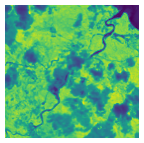

In [15]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

dpi = 50
fig = figure(figsize=(w / dpi, h / dpi), dpi=dpi, frameon=False)
ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
ax.set_axis_off()
fig.add_axes(ax)

plt.imshow(ndvi, cmap="viridis");